In [1]:
import warnings

import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
sns.set()

# Constantes

In [2]:
# Columnas a descartar
DROP_COLS = [
    "FechaLecturaActual",
    "FechaLecturaAnterior",
    "TipoLectura",
    "DiasFacturados",
    "RefacturacionConsumoUsuario",
    "ValorRefacturacionConsumoUsuario",
    "ValorRefacturacionSubsidioUsuario",
    "ValorRefacturacionContribucion",
    "ValorCarteraConsumo",
    "ValorCarteraContribuciones",
    "CargaContratada",
    "ConsumoEnergiaReactivaInductivaMedido",
    "ConsumoEnergiaReactivaInductivaFacturado",
    "ConsumoEnergiaReactivaCapacitivaMedido",
    "ConsumoEnergiaReactivaCapacitivaFacturado",
    "FacturacionConsumoEnergiaReactiva",
    "RefacturacionConsumoEnergiaReactivaInductiva",
    "RefacturacionConsumoEnergiaReactivaCapacitiva",
    "ValorRefacturacionEnergiaReactiva",
    "EnergiaActivaExportada",
    "ConsumoRecuperado",
    "ValorConsumoRecuperado",
    "RefacturacionConsumoRecuperado",
    "RefacturacionValorConsumoRecuperado",
    "ValorContribucionSubsidioRecuperado",
    "IdMercado",
    "DiasMora",
    "CondicionesEspeciales",
    "GrupoCalidad",
    "TipoMedidor",
    "ConsumoSubsistencia"
]

METRICS_COLS = [
    "ConsumoUsuario",
    "ValorFacturacionConsumoUsuario",
    "ValorSubsidioUsuario",
    "ValorContribucion",
    "ValorTotalFacturado",
    "VCVeces",
    "ConexionRed"
]

CHARACTS_COLS = [
    "Año",
    "Mes",
    "Mercado",
    "Tipo de medida",
    "NivelTension",
    "CodigoDane",
    "Ubicacion",
    "TipoAreaEspecial",
    "Uso - Estrato",
    "Altitud",
    "AutoGenerador",
    "FechaRegistroContable"
]

GROUPING_COLS = [
    "Año",
    "Mes",
    "IDD_PPS_Anonimo",
    "Mercado",
    "Tipo de medida",
    "NivelTension",
    "CodigoDane",
    "Ubicacion",
    "TipoAreaEspecial",
    "Uso - Estrato",
    "Altitud",
    "AutoGenerador",
    "FechaRegistroContable"
]

# Mappings
ubicacion_map = {
    1: "Rural Disperso",
    2: "Urbano",
    3: "Centro Poblado"
}


area_esp_map = {
    0: "Ninguna",
    1: "Barrio Subnormal",
    2: "Área Rural de Menor Desarrollo",
    3: "Zonas de Difícil Gestión"
}

estrato_map = {
    1: "Residencial Estrato 1",
    2: "Residencial Estrato 2",
    3: "Residencial Estrato 3",
    4: "Residencial Estrato 4",
    5: "Residencial Estrato 5",
    6: "Residencial Estrato 6",
    7: "Industrial",
    8: "Comercial",
    9: "Oficial",
    10: "Provisional",
    11: "Alumbrado Público",
}

auto_gen_map = {
    1: "Autogenerador Pequeña Escala",
    2: "Autogenerador Gran Escala",
    3: "No"
}

# Mappeo de Codigos Dane
df_geo = pl.read_csv("dane_geo.csv").with_columns(pl.col("CodigoDane").cast(pl.String).str.zfill(5))

# Funciones de Ayuda

In [3]:
def prepare_data(dataf):
    """Preparación inicial de los datos."""
    # Descartar columnas irrelevantes
    df_filtered = dataf.drop(DROP_COLS)

    # Seleccionar unicamente el mercado regulado
    df_filtered = df_filtered.filter(
        pl.col("Mercado") == "Regulado"
    )

    # Convertir columna 'FechaRegistroContable' a formato de fecha
    df_filtered = df_filtered.with_columns(
        pl.col("FechaRegistroContable").str.to_date(format="%d-%m-%Y").alias("FechaRegistroContable")
    )
    
    # Convertir el 'CodigoDane' a string
    df_filtered = df_filtered.with_columns(
        pl.col("CodigoDane") // 1000
    ).with_columns(
        pl.col("CodigoDane")
        .cast(pl.String)
        .str
        .zfill(5)
    )
    
    return df_filtered


def aggregate_client_metrics(dataf):
    df_agg = (
        dataf
        .group_by(GROUPING_COLS)
        .agg([
            pl.col(metric).sum()
            if metric != "ConexionRed"
            else pl.when(
                pl.col(metric) == 2
            ).then(1).otherwise(pl.col(metric)).alias("ConexionRed")
            for metric in METRICS_COLS
        ])
        .explode(pl.col("ConexionRed"))
        .unique()
    )
    return df_agg


def get_duplicated_ids(dataf):
    """Obtiene los 'IDD_PPS_Anonimo' duplicados en `dataf`."""
    dup_clients = dataf.select(pl.col("IDD_PPS_Anonimo")).is_duplicated()
    dup_ids = dataf.filter(
        dataf.select(
            pl.col("IDD_PPS_Anonimo")
        ).is_duplicated()
    ).select("IDD_PPS_Anonimo").unique()
    return dup_ids


def deduplicate_clients(df_agg, df_filtered, df_tmp, dup_ids):
    """Elimina los registros duplicados de 'IDD_PPS_Anonimo', dejando
    un solo registro por cliente y tomando las características
    corresponientes a la 'FechaRegistroContable' máxima cubriendo todos
    los posibles casos de registros duplicados.
    """
    
    # Calcular el conteo inicial de clientes únicos
    clientes_unicos_inicial = df_filtered.select("IDD_PPS_Anonimo").n_unique()

    # Seleccionar solo los registros duplicados de 'IDD_PPS_Anonimo' en las columnas de características
    df_characteristics = df_filtered.filter(
        df_filtered["IDD_PPS_Anonimo"].is_in(dup_ids)
    ).select(CHARACTS_COLS + ["IDD_PPS_Anonimo"])

    # Extraer la fecha máxima 'FechaRegistroContable' por cada 'IDD_PPS_Anonimo'
    max_dates = df_characteristics.select(["IDD_PPS_Anonimo", "FechaRegistroContable"]) \
                                  .group_by("IDD_PPS_Anonimo") \
                                  .max()

    # Obtener las características correspondientes a la fecha más reciente para cada cliente
    df_characteristics = max_dates.join(
        df_characteristics,
        on=["IDD_PPS_Anonimo", "FechaRegistroContable"],
        how="inner"
    ).unique().group_by(["IDD_PPS_Anonimo", "FechaRegistroContable"]).first()

    # Unir las características únicas con el dataframe temporal y agregar las métricas
    df_deduplicated = (
        df_tmp.join(df_characteristics, on="IDD_PPS_Anonimo", how="left", coalesce=True)
              .group_by(GROUPING_COLS)
              .agg([
                  pl.col(metric).sum() if metric != "ConexionRed" 
                  else pl.when(pl.col(metric) == 2).then(1).otherwise(pl.col(metric)).alias("ConexionRed")
                  for metric in METRICS_COLS
              ])
              .explode("ConexionRed")
              .unique()
    )

    # Verificar que no queden duplicados
    assert df_deduplicated.select("IDD_PPS_Anonimo").n_unique() == df_deduplicated.height, \
        "No se lograron remover todos los duplicados"

    # Concatenar el dataframe original con los registros deduplicados
    df_agg = pl.concat([
        df_agg.filter(~pl.col("IDD_PPS_Anonimo").is_in(dup_ids)),
        df_deduplicated.select(df_agg.columns)
    ])

    # Confirmar que el conteo final de clientes únicos coincide con el inicial
    clientes_unicos_final = df_agg.select("IDD_PPS_Anonimo").n_unique()
    assert clientes_unicos_final == df_agg.height == clientes_unicos_inicial, \
        "Todavía hay registros duplicados: revisar `df_agg`"

    return df_agg.drop(["FechaRegistroContable", "Mercado"])


def preprocess_month_data(dataf):
    # Ajustar tipos de datos y remover columnas innecesarias
    df_current = prepare_data(dataf)

    # Obtener el número total de clientes
    n_clients = df_current.select(pl.col("IDD_PPS_Anonimo")).n_unique()
    print(f"Clientes únicos: {n_clients:,}")

    # Agregar métricas por usuario
    df_agg = aggregate_client_metrics(df_current)

    # Obtener los ids de los clientes duplicados después de la agregación
    dup_ids = get_duplicated_ids(df_agg)

    # Obtener los registros correspondientes a los ids duplicados
    df_duplicated = df_agg.filter(pl.col("IDD_PPS_Anonimo").is_in(dup_ids))

    # Crear un dataframe temporal para remover las características descriptivas de los registros duplicados
    dataf_tmp = df_duplicated.drop(CHARACTS_COLS)

    # Remover registros duplicados del DataFrame de agregación
    df_deduplicated = deduplicate_clients(df_agg, df_current, dataf_tmp, dup_ids)
    
    return df_deduplicated.drop(["Año", "Mes"])


def preprocess_other_services(dataf, suffix):
    # Rellena consumos nulos con 0
    dataf = dataf.with_columns(pl.col("Consumo").fill_null(strategy="zero"))
    
    # Rellena posibles campos en columna 'Servicio' nulo con estrategia forward
    dataf = dataf.with_columns(pl.col("Servicio").fill_null(strategy="forward"))
    
    # Selecciona el servicio que se está trabajando
    service = dataf.select("Servicio").unique().to_numpy()[0][0]
    
    return (
        dataf
        .with_columns(pl.col("Consumo")
                      .alias(f"Consumo{service}_{suffix}"))
        .select(["IDD_PPS_Anonimo", f"Consumo{service}_{suffix}"])
        .group_by("IDD_PPS_Anonimo").sum()
    )

# 3.1 Datos Originales

In [4]:
# Carga de información energía
df_202408 = pl.read_csv("BaseEnergia_202408.csv", encoding="latin-1")
df_202407 = pl.read_csv("BaseEnergia_202407.csv", encoding="latin-1")

# Carga de información de acueducto
df_acu_202408 = pl.read_csv("BaseAcueducto_202408.csv", encoding="utf-8")
df_acu_202407 = pl.read_csv("BaseAcueducto_202407.csv", encoding="utf-8")

# Carga de información de alcantarillado
df_alc_202408 = pl.read_csv("BaseAlcantarillado_202408.csv", encoding="utf-8")
df_alc_202407 = pl.read_csv("BaseAlcantarillado_202407.csv", encoding="utf-8")

# Carga de información de gas
df_gas_202408 = pl.read_csv("BaseGas_202408.csv", encoding="utf-8")
df_gas_202407 = pl.read_csv("BaseGas_202407.csv", encoding="utf-8")

In [5]:
# Información dataset consumo energía
print(df_202408.shape)
df_202408.schema

(2837817, 51)


OrderedDict([('Año', Int64),
             ('Mes', Int64),
             ('IDD_PPS_Anonimo', String),
             ('Mercado', String),
             ('Tipo de medida', String),
             ('NivelTension', Int64),
             ('ConexionRed', Int64),
             ('GrupoCalidad', Int64),
             ('CodigoDane', Int64),
             ('Ubicacion', Int64),
             ('CondicionesEspeciales', Int64),
             ('TipoAreaEspecial', Int64),
             ('Uso - Estrato', Int64),
             ('Altitud', Int64),
             ('AutoGenerador', Int64),
             ('FechaLecturaActual', String),
             ('FechaLecturaAnterior', String),
             ('DiasFacturados', Int64),
             ('TipoLectura', Int64),
             ('ConsumoUsuario', Int64),
             ('ConsumoSubsistencia', Int64),
             ('ValorFacturacionConsumoUsuario', Int64),
             ('RefacturacionConsumoUsuario', Int64),
             ('ValorRefacturacionConsumoUsuario', Int64),
             ('Valor

In [6]:
# Información dataset consumo acueducto
print(df_acu_202408.shape)
df_acu_202408.schema

(1420975, 4)


OrderedDict([('FecContable', Int64),
             ('IDD_PPS_Anonimo', String),
             ('Servicio', String),
             ('Consumo', Int64)])

In [7]:
# Información dataset consumo alcantarillado
df_alc_202408.schema

OrderedDict([('FecContable', Int64),
             ('IDD_PPS_Anonimo', String),
             ('Servicio', String),
             ('Consumo', Int64)])

In [8]:
# Información dataset consumo gas
df_gas_202408.schema

OrderedDict([('FecContable', Int64),
             ('IDD_PPS_Anonimo', String),
             ('Servicio', String),
             ('Consumo', Int64)])

# 3.2 Dataset
Construcción de dataset de entrenamiento y prueba.

In [9]:
# Preparar los datasets de energia de cada mes
df_base = preprocess_month_data(df_202408).with_columns(
    pl.col("ConsumoUsuario").alias("ConsumoEnergia_202408")
).drop(["ConsumoUsuario"])
df_202407_agg = preprocess_month_data(df_202407).select([
    pl.col("IDD_PPS_Anonimo"),
    pl.col("ConsumoUsuario").alias("ConsumoEnergia_202407")
])

# Preparar datasets de acueducto
df_acu_202408 = preprocess_other_services(df_acu_202408, "202408")
df_acu_202407 = preprocess_other_services(df_acu_202407, "202407")

# Preparar datasets de alcantarillado
df_alc_202408 = preprocess_other_services(df_alc_202408, "202408")
df_alc_202407 = preprocess_other_services(df_alc_202407, "202407")

# Preparar datasets de gas
df_gas_202408 = preprocess_other_services(df_gas_202408, "202408")
df_gas_202407 = preprocess_other_services(df_gas_202407, "202407")

Clientes únicos: 2,833,482
Clientes únicos: 2,827,222


In [10]:
# Unión de los consumos de los diferentes servicios con el dataset base
df_merge = (
    df_base
    .join(
        df_202407_agg,
        on="IDD_PPS_Anonimo",
        how="left",
        coalesce=True
    )
    .join(
        df_acu_202408,
        on="IDD_PPS_Anonimo",
        how="left",
        coalesce=True
    )
    .join(
        df_acu_202407,
        on="IDD_PPS_Anonimo",
        how="left",
        coalesce=True
    )
    .join(
        df_alc_202408,
        on="IDD_PPS_Anonimo",
        how="left",
        coalesce=True
    )
    .join(
        df_alc_202407,
        on="IDD_PPS_Anonimo",
        how="left",
        coalesce=True
    )
    .join(
        df_gas_202408,
        on="IDD_PPS_Anonimo",
        how="left",
        coalesce=True
    )
    .join(
        df_gas_202407,
        on="IDD_PPS_Anonimo",
        how="left",
        coalesce=True
    )
)
df_merge = df_merge.fill_null(0).fill_nan(0)

In [11]:
# Aplicar mappeos
df_merge = df_merge.with_columns(
    pl.col("Ubicacion").replace(ubicacion_map).alias("Ubicacion")
)
df_merge = df_merge.with_columns(
    pl.col("TipoAreaEspecial").replace(area_esp_map).alias("TipoAreaEspecial")
)
df_merge = df_merge.with_columns(
    pl.col("Uso - Estrato").replace(estrato_map).alias("Uso - Estrato")
)
df_merge = df_merge.with_columns(
    pl.col("AutoGenerador").replace(auto_gen_map).alias("AutoGenerador")
)
df_merge = df_merge.join(
    df_geo, on="CodigoDane", how="left", coalesce=True
).drop(["CodigoDane"])

In [12]:
df_merge.sample(5)

IDD_PPS_Anonimo,Tipo de medida,NivelTension,Ubicacion,TipoAreaEspecial,Uso - Estrato,Altitud,AutoGenerador,ValorFacturacionConsumoUsuario,ValorSubsidioUsuario,ValorContribucion,ValorTotalFacturado,VCVeces,ConexionRed,ConsumoEnergia_202408,ConsumoEnergia_202407,ConsumoAcueducto_202408,ConsumoAcueducto_202407,ConsumoAlcantarillado_202408,ConsumoAlcantarillado_202407,ConsumoGas_202408,ConsumoGas_202407,Region,Municipio
str,str,i64,str,str,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str
"""84321CAE5A020DCBCA8D873F8D488F…","""Pospago""",1,"""Urbano""","""Ninguna""","""Residencial Estrato 5""",1680,"""No""",74172,0,14834,89006,0,1,88,85,3,3,3,3,9,12,"""VALLE DE ABURRA""","""ENVIGADO"""
"""A5CF478CDCC8DFC96E30D75A71843F…","""Pospago""",1,"""Urbano""","""Ninguna""","""Residencial Estrato 6""",1802,"""No""",104515,0,20903,125418,0,1,124,149,3,4,3,4,5,14,"""VALLE DE ABURRA""","""MEDELLÍN"""
"""760B9467C12244B250FEF94189AC37…","""Pospago""",1,"""Urbano""","""Ninguna""","""Residencial Estrato 3""",1590,"""No""",96929,14539,0,82404,0,1,115,113,16,16,16,16,12,12,"""VALLE DE ABURRA""","""SABANETA"""
"""3DC2F2EA6435FAA850EE15973B0BA0…","""Pospago""",1,"""Urbano""","""Ninguna""","""Residencial Estrato 2""",1728,"""No""",60686,26568,0,75683,0,1,72,81,0,0,0,0,0,0,"""VALLE DE ABURRA""","""MEDELLÍN"""
"""BAFF48BF06DE8F31BB8AB3A7AB8F67…","""Pospago""",1,"""Urbano""","""Ninguna""","""Residencial Estrato 1""",31,"""No""",155929,80233,0,76105,0,1,185,193,0,0,0,0,14,14,"""URABA""","""CHIGORODÓ"""


# 3.3 Analítica Descriptiva
## 3.3.1 Variables Categóricas

<Axes: ylabel='count'>

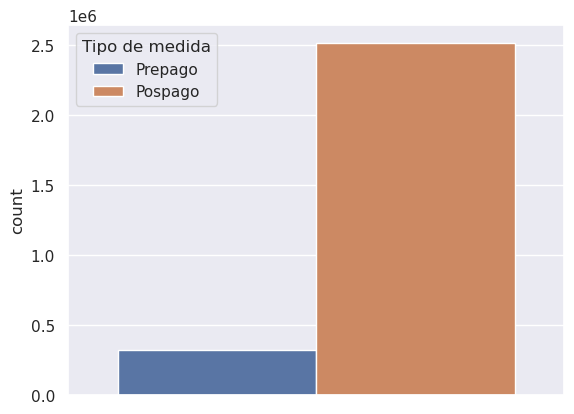

In [13]:
sns.barplot(
    data=df_merge["Tipo de medida"].value_counts(),
    y="count",
    hue="Tipo de medida",
)

<Axes: ylabel='count'>

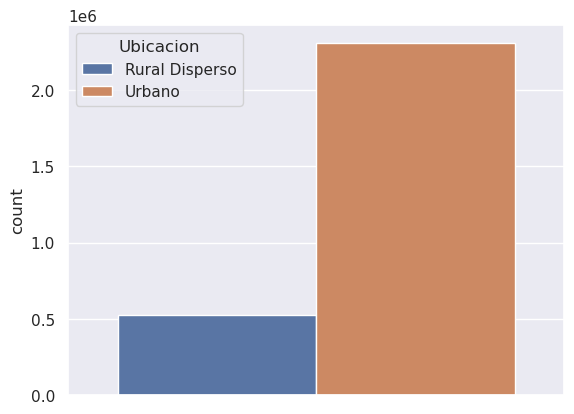

In [14]:
sns.barplot(
    data=df_merge["Ubicacion"].value_counts(),
    y="count",
    hue="Ubicacion",
)

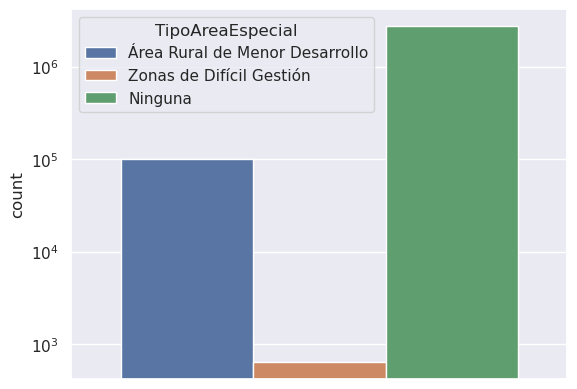

In [15]:
sns.barplot(
    data=df_merge["TipoAreaEspecial"].value_counts(),
    y="count",
    hue="TipoAreaEspecial",
)
plt.yscale("log")

In [16]:
# Se remueve la columna 'TipoAreaEspecial'
df_merge = df_merge.drop(["TipoAreaEspecial"])

<Axes: ylabel='count'>

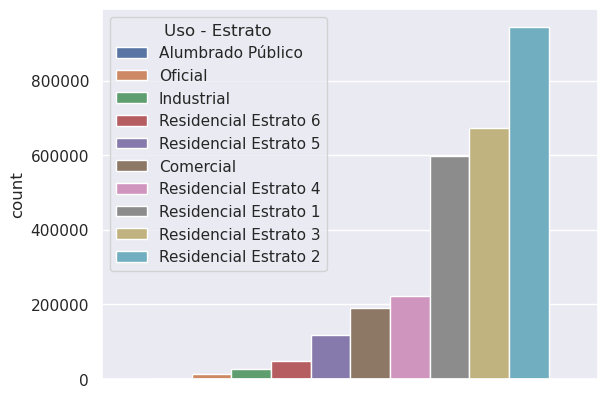

In [17]:
sns.barplot(
    data=df_merge["Uso - Estrato"].value_counts().sort(by="count"),
    y="count",
    hue="Uso - Estrato",
)

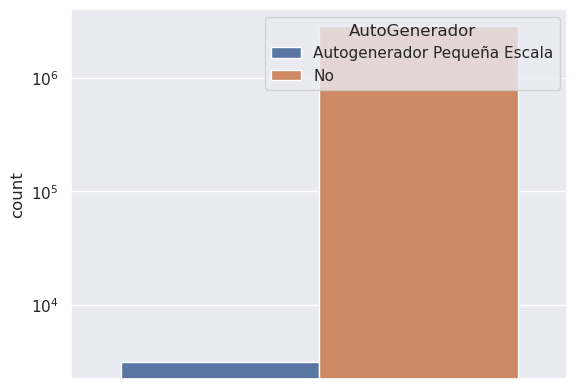

In [18]:
sns.barplot(
    data=df_merge["AutoGenerador"].value_counts().sort(by="count"),
    y="count",
    hue="AutoGenerador",
)
plt.yscale("log")

In [19]:
# Se remueve la columna 'AutoGenerador'
df_merge = df_merge.drop(["AutoGenerador"])

<Axes: ylabel='count'>

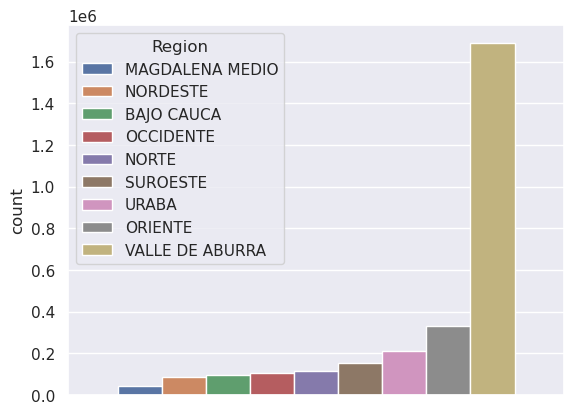

In [20]:
sns.barplot(
    data=df_merge["Region"].value_counts().sort(by="count"),
    y="count",
    hue="Region",
)

In [21]:
# Valores únicos de municipios
df_merge["Municipio"].n_unique()

123

## 3.3.2 Variables Numéricas

In [22]:
# Variables
num_vars = ['ValorSubsidioUsuario',
 'ValorContribucion',
 'ValorTotalFacturado',
 'VCVeces',
 'ConsumoEnergia_202408',
 'ConsumoEnergia_202407',
 'ConsumoAcueducto_202408',
 'ConsumoAcueducto_202407',
 'ConsumoAlcantarillado_202408',
 'ConsumoAlcantarillado_202407',
 'ConsumoGas_202408',
 'ConsumoGas_202407',
 'Region',
 'Municipio']
num_vars

['ValorSubsidioUsuario',
 'ValorContribucion',
 'ValorTotalFacturado',
 'VCVeces',
 'ConsumoEnergia_202408',
 'ConsumoEnergia_202407',
 'ConsumoAcueducto_202408',
 'ConsumoAcueducto_202407',
 'ConsumoAlcantarillado_202408',
 'ConsumoAlcantarillado_202407',
 'ConsumoGas_202408',
 'ConsumoGas_202407',
 'Region',
 'Municipio']

In [23]:
# Consumo de energía agrupado por 'Uso - Estrato'
df_merge.select(
    ["Uso - Estrato", "ConsumoEnergia_202407", "ConsumoEnergia_202408"]
).to_pandas().groupby("Uso - Estrato").describe()

ConsumoEnergia_202407                                   \
                                      count          mean           std  min   
Uso - Estrato                                                                  
Alumbrado Público                     338.0  14568.372781  36168.691075  0.0   
Comercial                          190462.0    660.961730   2856.461628  0.0   
Industrial                          26949.0   2686.442874  13414.897266  0.0   
Oficial                             13291.0   1470.363930  11596.757226  0.0   
Residencial Estrato 1              598813.0     97.508381    133.863527  0.0   
Residencial Estrato 2              943461.0    116.364461    152.043480  0.0   
Residencial Estrato 3              671874.0    131.686784    220.161783  0.0   
Residencial Estrato 4              222821.0    156.253087    456.623238  0.0   
Residencial Estrato 5              117603.0    184.382048    437.909297  0.0   
Residencial Estrato 6               47870.0    259.746396    668.627941  0.0   

                                                           \
                         25%     50%       75%        max   
Uso - Estrato                                               
Alumbrado Público      718.5  1565.0  11049.25   288531.0   
Comercial               42.0   186.0    551.00   532400.0   
Industrial               4.0   369.0   1800.00  1076398.0   
Oficial                  0.0   125.0    651.50   844800.0   
Residencial Estrato 1    0.0    76.0    139.00    12134.0   
Residencial Estrato 2   47.0    95.0    149.00    13500.0   
Residencial Estrato 3   65.0   105.0    156.00    40240.0   
Residencial Estrato 4   68.0   108.0    160.00    34040.0   
Residencial Estrato 5   80.0   126.0    188.00    26500.0   
Residencial Estrato 6   99.0   156.0    240.00    28560.0   

                      ConsumoEnergia_202408                                   \
                                      count          mean           std  min   
Uso - Estrato                                                                  
Alumbrado Público                     338.0  14880.816568  36463.820699  0.0   
Comercial                          190462.0    694.561787   4444.859283  0.0   
Industrial                          26949.0   2827.451928  14297.449081  0.0   
Oficial                             13291.0   1556.075615  12136.905338  0.0   
Residencial Estrato 1              598813.0     98.136450    146.004229  0.0   
Residencial Estrato 2              943461.0    117.342317    160.363280  0.0   
Residencial Estrato 3              671874.0    133.355529    228.615369  0.0   
Residencial Estrato 4              222821.0    158.860354    469.665919  0.0   
Residencial Estrato 5              117603.0    192.414012    474.547601  0.0   
Residencial Estrato 6               47870.0    279.191080    714.863943  0.0   

                                                           
                          25%     50%      75%        max  
Uso - Estrato                                              
Alumbrado Público      796.25  1649.5  11222.0   283385.0  
Comercial               44.00   192.0    570.0  1217436.0  
Industrial               7.00   394.0   1933.0  1054931.0  
Oficial                  0.00   137.0    696.0   924000.0  
Residencial Estrato 1    0.00    76.0    138.0    32180.0  
Residencial Estrato 2   47.00    95.0    149.0    17200.0  
Residencial Estrato 3   65.00   106.0    157.0    44800.0  
Residencial Estrato 4   68.00   109.0    161.0    34600.0  
Residencial Estrato 5   83.00   130.0    195.0    28290.0  
Residencial Estrato 6  106.00   167.0    257.0    28320.0

In [24]:
# Consumo de energía agrupado por 'Region'
df_merge.select(
    ["Region", "ConsumoEnergia_202407","ConsumoEnergia_202408"]
).to_pandas().groupby(["Region"]).describe()

ConsumoEnergia_202407                                      \
                                count        mean          std  min   25%   
Region                                                                      
BAJO CAUCA                    98151.0  189.886073  1441.955667  0.0  13.0   
MAGDALENA MEDIO               45375.0  230.536419  2263.494586  0.0   6.0   
NORDESTE                      86513.0  183.149480  2801.964807  0.0   0.0   
NORTE                        112846.0  190.576875  3878.562518  0.0   0.0   
OCCIDENTE                    103752.0  141.215658   743.830261  0.0   0.0   
ORIENTE                      330552.0  182.457483  2037.232758  0.0  23.0   
SUROESTE                     155636.0  130.480493  1022.484698  0.0   0.0   
URABA                        210804.0  173.192193  1460.875942  0.0   0.0   
VALLE DE ABURRA             1689853.0  207.182994  1585.036802  0.0  67.0   

                                         ConsumoEnergia_202408              \
                   50%    75%        max                 count        mean   
Region                                                                       
BAJO CAUCA       118.0  202.0   256899.0               98151.0  195.554717   
MAGDALENA MEDIO  115.0  207.0   362219.0               45375.0  250.799383   
NORDESTE          72.0  142.0   445440.0               86513.0  179.666524   
NORTE             56.0  130.0   844800.0              112846.0  212.545248   
OCCIDENTE         49.0  142.0    82560.0              103752.0  136.725702   
ORIENTE           88.0  158.0   532400.0              330552.0  179.011711   
SUROESTE          55.0  119.0   147280.0              155636.0  139.105734   
URABA            104.0  180.0   288531.0              210804.0  182.287718   
VALLE DE ABURRA  108.0  162.0  1076398.0             1689853.0  213.699616   

                                                                  
                         std  min   25%    50%    75%        max  
Region                                                            
BAJO CAUCA       1514.349381  0.0  14.0  117.0  204.0   256899.0  
MAGDALENA MEDIO  2220.673037  0.0  21.0  124.0  220.0   279191.0  
NORDESTE         2846.847175  0.0   0.0   69.0  137.0   445440.0  
NORTE            4583.634364  0.0   0.0   56.0  130.0  1020800.0  
OCCIDENTE         780.675389  0.0   0.0   44.0  137.0    95820.0  
ORIENTE          2056.456482  0.0  14.0   86.0  154.0   584000.0  
SUROESTE         1056.457347  0.0   0.0   59.0  125.0   159280.0  
URABA            1527.793098  0.0   5.0  106.0  184.0   313987.0  
VALLE DE ABURRA  1968.229641  0.0  68.0  109.0  163.0  1217436.0

### Tratamiento de Outliers

In [25]:
def get_list_mappings(ref_cols: list, prefix="threshold"):
    """Retorna un diccionario de valores para cada valor en `ref_cols`."""
    mapping_dict = {
        ref_col: f"{prefix}_{ref_col.split('_')[1]}"
        for ref_col in ref_cols
    }
    return mapping_dict


def calculate_outlier_thresholds(dataf, ref_cols: list, group_col:str="Uso - Estrato"):
    """Calcula el umbral de valores superiores para la
    columna `ref_col`, agrupada por la columna `group_col` y los
    regresa como DataFrame, donde cada valor agrupado contiene su umbral
    superior calculado para determinar outliers.
    
    Parameters
    ----------
    dataf: DataFrame
    ref_cols: list
        Lista de las columnas a usar como referencia para calcular
        los umbrales, estas deben finalizar como '_AñoMes', por ej.
        '_202408'
    group_col: str
        Nombre de la columna a utilizar como agrupadora para
        determinar umbrales por cada categoría.
    
    Returns
    -------
    DataFrame
    """
    # Determinar columnas para seleccionar
    select_cols = ref_cols + [group_col]
    
    # Determinar los sufijos a usar por cada valor en `ref_cols`
    suffixes = get_list_mappings(ref_cols)
    
    # Calcular el cuartil 3 (75%)
    q3 = (
        df_merge
        .select(select_cols)
        .group_by(group_col)
        .quantile(0.75)
    )
    
    # Calcular el rango intercuartil superior para usar como umbral
    outlier_thresholds = q3.with_columns([pl.col(ref_col) * 1.5 for ref_col in ref_cols])
    outlier_thresholds = outlier_thresholds.rename(suffixes)
    
    return outlier_thresholds


def label_outliers(dataf, outlier_thresholds, ref_cols:list, join_col:str="Uso - Estrato"):
    """Agrega columnas indicadoras de outliers a `dataf`."""
    # Obtener los nombres de los umbrales respectivos para cada columna
    thresholds = get_list_mappings(ref_cols)
    
    # Obtener el nombre correspondiente de la columna de outliers para cada umbral
    outliers = get_list_mappings(list(thresholds.values()), prefix="outlier")

    # Unir los valores de los umbrales con el `dataf` base
    df_with_threshold = dataf.join(
        outlier_thresholds,
        on=join_col,
        how="left"
    )
    
    # Etiquetar los registros cuyo valor en `ref_col` exceda el umbral respectivo
    return df_with_threshold.with_columns(
        [
            pl.when(pl.col(k) > pl.col(v))
            .then(True)
            .otherwise(False)
            .alias(outliers[v])
            for k,v in thresholds.items()
        ]
    )

In [26]:
# Calcular umbrales por 'Uso - Estrato' para determinar outliers
outlier_thresholds = calculate_outlier_thresholds(
    df_merge, ["ConsumoEnergia_202408", "ConsumoEnergia_202407"]
)

# Agregar columna que marque como outlier por el consumo en el mes X para cada uno de los meses
df_labeled = label_outliers(df_merge, outlier_thresholds, ["ConsumoEnergia_202408", "ConsumoEnergia_202407"])

# Si al menos una de las columnas indicadoras de outliers es True, el registro se separa del dataset
df_labeled = df_labeled.with_columns((pl.col("outlier_202408") | pl.col("outlier_202407")).alias("outlier"))

# Borrar las columnas de ayuda
df_labeled = df_labeled.drop([col for col in df_labeled.columns if "outlier_" in col or "threshold_" in col])

In [27]:
# Contar outliers
df_labeled.select("outlier").sum()

outlier
u32
381923


In [28]:
# Separar dataset sin outliers y con outliers para guardar
df_clean = df_labeled.filter(pl.col("outlier")==False).drop("outlier")
df_outliers = df_labeled.filter(pl.col("outlier")==True).drop("outlier")

print(f"Dataset sin outliers: {df_clean.height:,}")
print(f"Dataset con outliers: {df_outliers.height:,}")

Dataset sin outliers: 2,451,559
Dataset con outliers: 381,923


In [29]:
# Consumo de energía agrupado por 'Uso - Estrato'
df_clean.select(
    ["Uso - Estrato", "ConsumoEnergia_202407", "ConsumoEnergia_202408"]
).to_pandas().groupby("Uso - Estrato").describe()

ConsumoEnergia_202407                                 \
                                      count         mean          std  min   
Uso - Estrato                                                                
Alumbrado Público                     279.0  3126.946237  4280.335056  0.0   
Comercial                          154340.0   190.935733   202.266734  0.0   
Industrial                          21256.0   494.672610   658.361479  0.0   
Oficial                             10394.0   161.702040   230.477587  0.0   
Residencial Estrato 1              507100.0    69.311895    60.630409  0.0   
Residencial Estrato 2              822181.0    87.260061    57.974849  0.0   
Residencial Estrato 3              596084.0    98.382906    56.056842  0.0   
Residencial Estrato 4              196027.0   100.770685    56.764845  0.0   
Residencial Estrato 5              102645.0   117.850076    64.476096  0.0   
Residencial Estrato 6               41253.0   147.098150    80.465518  0.0   

                                                       ConsumoEnergia_202408  \
                         25%     50%      75%      max                 count   
Uso - Estrato                                                                  
Alumbrado Público      576.5  1309.0  2905.50  16386.0                 279.0   
Comercial               24.0   122.0   296.00    826.0              154340.0   
Industrial               0.0   199.0   741.25   2700.0               21256.0   
Oficial                  0.0    40.0   257.00    978.0               10394.0   
Residencial Estrato 1    0.0    66.0   118.00    208.0              507100.0   
Residencial Estrato 2   44.0    87.0   129.00    223.0              822181.0   
Residencial Estrato 3   61.0    98.0   137.00    234.0              596084.0   
Residencial Estrato 4   64.0   100.0   139.00    240.0              196027.0   
Residencial Estrato 5   74.0   115.0   161.00    282.0              102645.0   
Residencial Estrato 6   91.0   141.0   199.00    360.0               41253.0   

                                                                             \
                              mean          std  min    25%     50%     75%   
Uso - Estrato                                                                 
Alumbrado Público      3160.634409  4307.048603  0.0  639.5  1347.0  2785.0   
Comercial               196.947324   208.513427  0.0   25.0   125.0   306.0   
Industrial              521.219609   692.873399  0.0    0.0   206.5   780.0   
Oficial                 171.132673   241.351962  0.0    0.0    46.0   270.0   
Residencial Estrato 1    69.023847    60.249313  0.0    0.0    66.0   117.0   
Residencial Estrato 2    87.835237    58.315491  0.0   44.0    88.0   130.0   
Residencial Estrato 3    99.307148    56.770075  0.0   61.0    98.0   138.0   
Residencial Estrato 4   101.466716    57.116301  0.0   64.0   100.0   140.0   
Residencial Estrato 5   121.858434    66.700991  0.0   77.0   119.0   166.0   
Residencial Estrato 6   157.485056    86.108153  0.0   98.0   150.0   213.0   

                                
                           max  
Uso - Estrato                   
Alumbrado Público      16386.0  
Comercial                855.0  
Industrial              2887.0  
Oficial                 1045.0  
Residencial Estrato 1    207.0  
Residencial Estrato 2    223.0  
Residencial Estrato 3    235.0  
Residencial Estrato 4    241.0  
Residencial Estrato 5    292.0  
Residencial Estrato 6    385.0

In [30]:
# Consumo de energía agrupado por 'Uso - Estrato'
df_outliers.select(
    ["Uso - Estrato", "ConsumoEnergia_202407", "ConsumoEnergia_202408"]
).to_pandas().groupby("Uso - Estrato").describe()

ConsumoEnergia_202407                                   \
                                      count          mean           std  min   
Uso - Estrato                                                                  
Alumbrado Público                      59.0  68672.745763  62495.358293  0.0   
Comercial                           36122.0   2669.261724   6153.947335  0.0   
Industrial                           5693.0  10869.873178  27666.865385  0.0   
Oficial                              2897.0   6165.645841  24264.623601  0.0   
Residencial Estrato 1               91713.0    253.412537    260.715636  0.0   
Residencial Estrato 2              121280.0    313.668923    335.227155  0.0   
Residencial Estrato 3               75790.0    393.619871    572.408368  0.0   
Residencial Estrato 4               26794.0    562.166679   1234.151585  0.0   
Residencial Estrato 5               14958.0    640.938695   1113.740283  0.0   
Residencial Estrato 6                6617.0    962.040199   1619.218418  0.0   

                                                              \
                           25%      50%       75%        max   
Uso - Estrato                                                  
Alumbrado Público      29106.5  42105.0  84705.50   288531.0   
Comercial               1033.0   1478.0   2537.75   532400.0   
Industrial              3314.0   5166.0   9800.00  1076398.0   
Oficial                 1240.0   2033.0   4100.00   844800.0   
Residencial Estrato 1    159.0    237.0    316.00    12134.0   
Residencial Estrato 2    224.0    264.0    353.00    13500.0   
Residencial Estrato 3    242.0    286.0    393.00    40240.0   
Residencial Estrato 4    251.0    308.0    463.00    34040.0   
Residencial Estrato 5    303.0    380.0    589.00    26500.0   
Residencial Estrato 6    394.0    504.0    817.00    28560.0   

                      ConsumoEnergia_202408                              \
                                      count          mean           std   
Uso - Estrato                                                             
Alumbrado Público                      59.0  70303.372881  62058.016304   
Comercial                           36122.0   2820.740186   9920.188352   
Industrial                           5693.0  11438.250132  29529.158142   
Oficial                              2897.0   6525.042458  25381.113519   
Residencial Estrato 1               91713.0    259.106005    297.518119   
Residencial Estrato 2              121280.0    317.376624    362.054622   
Residencial Estrato 3               75790.0    401.144096    597.623819   
Residencial Estrato 4               26794.0    578.756699   1268.930137   
Residencial Estrato 5               14958.0    676.581495   1213.057823   
Residencial Estrato 6                6617.0   1037.954662   1727.158828   

                                                                       
                           min      25%      50%       75%        max  
Uso - Estrato                                                          
Alumbrado Público      18069.0  29106.5  46053.0  87954.50   283385.0  
Comercial                  0.0   1064.0   1522.0   2611.75  1217436.0  
Industrial                 0.0   3480.0   5430.0  10400.00  1054931.0  
Oficial                    0.0   1378.0   2204.0   4640.00   924000.0  
Residencial Estrato 1      0.0    165.0    238.0    320.00    32180.0  
Residencial Estrato 2      0.0    225.0    266.0    355.00    17200.0  
Residencial Estrato 3      0.0    245.0    290.0    398.00    44800.0  
Residencial Estrato 4      0.0    254.0    312.0    479.00    34600.0  
Residencial Estrato 5      0.0    315.0    396.0    614.00    28290.0  
Residencial Estrato 6      0.0    417.0    531.0    878.00    28320.0